# NY Housing Price - regression
## Part 3. Model Selection
<br>

<a id = 'toc'></a>
**Table of Contents**
1. [Model comparison criteria](#cv)
2. [Baseline model](#base)
3. [Model selection with GridSearch](#select)
    1. [create pipeline](#pipe)
    2. [declare hyperparameter grid](#hyper)
    3. [model training/tuning/selection](#select)
4. [Parameter tuning with Baysian Optimization](#hyperopt)
    - save final models
5. [Feature importance](#imp)

In [125]:
# import libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold, cross_validate, GridSearchCV, cross_val_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import make_scorer, r2_score, mean_absolute_error

from hyperopt import fmin, hp, tpe, Trials, STATUS_OK, space_eval
from hyperopt.pyll import stochastic, scope
import pprint

import pickle

In [2]:
#load analytical base table
df = pd.read_csv('../data/analytical_base_table.csv')

In [3]:
df.shape

(1505, 48)

In [4]:
df.head()

,tx_price,beds,baths,sqft,lot_size,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,2ba2be,recession_ind,property_age,age_neg_ind,school_score,ba2be,property_type_Apartment / Condo / Townhouse,property_type_Single-Family,exterior_walls_Brick,exterior_walls_Brick veneer,exterior_walls_Combination,exterior_walls_Concrete,exterior_walls_Masonry,exterior_walls_Metal,exterior_walls_Missing,exterior_walls_Other,exterior_walls_Siding (Alum/Vinyl),exterior_walls_Stucco,exterior_walls_Wood,roof_Asphalt,roof_Composition Shingle,roof_Gravel/Rock,roof_Missing,roof_Other,roof_Roll Composition,roof_Shake Shingle,roof_Wood Shake/ Shingles
0,257840,4,2,3796,20473,1.0,0,0,0,0,1,0,0,0,49.0,91.0,83.0,593.0,181.0,8.0,1.0,0,0,19,False,8.0,0.50,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,540000,4,3,2500,10500,1.0,19,2,2,1,21,0,11,9,46.0,94.0,54.0,487.0,148.0,8.0,3.0,0,1,42,False,24.0,0.75,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,300000,4,3,3480,10890,1.0,32,2,5,8,36,8,25,35,45.0,81.0,88.0,1015.0,337.0,4.0,3.0,0,0,53,False,12.0,0.75,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,650000,5,4,5809,30056,1.0,4,0,1,0,4,0,5,8,37.0,64.0,55.0,727.0,187.0,7.0,3.0,0,0,2,False,21.0,0.80,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,576145,4,3,3504,4199,1.0,20,3,1,1,12,1,12,5,34.0,91.0,59.0,528.0,161.0,7.0,2.0,0,0,1,False,14.0,0.75,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [5]:
# create X, y
y = df['tx_price']
X = df.drop('tx_price', axis = 1)

In [6]:
print (X.shape, y.shape)

(1505, 47) (1505,)


[back to top](#toc)
<a id = 'cv'></a>
### 1. Determine model comparison criteria

In [7]:
# cross validation creteria
cv = KFold(n_splits = 5, shuffle = True, random_state = 26)
#scoring = {'r2': make_scorer(r2_score),
#           'MAE':make_scorer(mean_absolute_error, greater_is_better=False)}
scoring = 'neg_mean_absolute_error'
n_jobs = -1
max_evals = 50

[back to top](#toc)
<a id = 'base'></a>
### 2. Baseline model

In [8]:
scores = cross_validate(DummyRegressor(strategy = 'mean'), 
                        X, y, 
                        cv = cv, 
                        scoring = scoring, 
                        n_jobs = n_jobs)

In [9]:
#print (scores['test_r2'].mean())
print (-scores['test_score'].mean())

125301.15313627885



**Notes:**

**MAE >120K**

[back to top](#toc)
<a id = 'select'></a>
### 3. Model selection with GridSearch

#### 3.1. Create pipelines

In [62]:
linear_pipelines = {'lasso': make_pipeline(StandardScaler(), Lasso(random_state = 26)),
                    'ridge': make_pipeline(StandardScaler(), Ridge(random_state = 26)),
                    'enet': make_pipeline(StandardScaler(), ElasticNet(random_state = 26)),
                   'svr': make_pipeline(StandardScaler(), SVR())}
tree_pipelines = {'rf': make_pipeline(StandardScaler(), RandomForestRegressor(random_state =26)),
                 'et': make_pipeline(StandardScaler(), ExtraTreesRegressor(random_state=26)),
                  'adab': make_pipeline(StandardScaler(), AdaBoostRegressor(random_state=26)),
                 'xgb': make_pipeline(StandardScaler(), XGBRegressor(random_state=26))}

In [11]:
def check_pipes(pipelines):
    for n, p in pipelines.items():
        print (n, type(p))

In [12]:
check_pipes(linear_pipelines)

lasso <class 'sklearn.pipeline.Pipeline'>
ridge <class 'sklearn.pipeline.Pipeline'>
enet <class 'sklearn.pipeline.Pipeline'>
svr <class 'sklearn.pipeline.Pipeline'>


In [63]:
check_pipes(tree_pipelines)

rf <class 'sklearn.pipeline.Pipeline'>
et <class 'sklearn.pipeline.Pipeline'>
adab <class 'sklearn.pipeline.Pipeline'>
xgb <class 'sklearn.pipeline.Pipeline'>


<a id = 'hyper'></a>
#### 3.2. Declare hyperparameter grid

In [35]:
# model_hyperparameters = {'model__param':[values]}
lasso_hyperparameters = {'lasso__alpha': [0.01, 0.1, 1.0, 10, 100]}
ridge_hyperparameters = {'ridge__alpha': [0.01, 0.1, 1.0, 10, 100]}
enet_hyperparameters = {'elasticnet__alpha': [0.01, 0.1, 1.0, 10, 100],
                       'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
svr_hyperparameters = {'svr__C': [0.01, 0.1, 1.0, 10, 100],
                      'svr__kernel': ['linear', 'rbf']}

In [36]:
linear_hyperparameters = {'lasso': lasso_hyperparameters,
                         'ridge': ridge_hyperparameters,
                         'enet': enet_hyperparameters,
                         'svr': svr_hyperparameters}

In [52]:
rf_hyperparameters = {'randomforestregressor__n_estimators': [300,],
                     'randomforestregressor__max_features': [None, 'sqrt', 'log2']}
et_hyperparameters = {'extratreesregressor__n_estimators': [300,],
                     'extratreesregressor__max_features': [None, 'sqrt', 'log2']}
adab_hyperparameters = {'adaboostregressor__n_estimators': [300,],
                       'adaboostregressor__learning_rate': [0.01, 0.1, 1.0]}
xgb_hyperparameters = {'xgbregressor__n_estimators': [300],
                      'xgbregressor__learning_rate': [0.01, 0.03, 0.1],
                      'xgbregressor__max_depth': [3,5,7]}

In [53]:
tree_hyperparameters = {'rf': rf_hyperparameters,
                       'et': et_hyperparameters,
                       'adab': adab_hyperparameters,
                       'xgb': xgb_hyperparameters}

In [39]:
def check_hyperparameters_setup(hyperparameters):
    for key in hyperparameters.keys():
        if type(hyperparameters[key]) is dict:
            print (key, 'was found in hyperparameters, and it is a grid.')
        else:
            print (key, 'was found in hyperparameters, but it is not a grid.')

In [40]:
check_hyperparameters_setup(linear_hyperparameters)

lasso was found in hyperparameters, and it is a grid.
ridge was found in hyperparameters, and it is a grid.
enet was found in hyperparameters, and it is a grid.
svr was found in hyperparameters, and it is a grid.


In [54]:
check_hyperparameters_setup(tree_hyperparameters)

rf was found in hyperparameters, and it is a grid.
et was found in hyperparameters, and it is a grid.
adab was found in hyperparameters, and it is a grid.
xgb was found in hyperparameters, and it is a grid.


<a id = 'select'></a>
#### 3.3. Model selection

In [42]:
# refit= setting for multi metric
#print(refit)

In [43]:
def fit_models(pipelines, hyperparameters, cv, scoring): #refit):
    fitted_models = {}
    for name, pipeline in pipelines.items():
        model = GridSearchCV(pipeline, hyperparameters[name], 
                             cv=cv, scoring=scoring, n_jobs = -1)#, refit = refit )
        model.fit(X, y)
        fitted_models[name] = model
        print (name, 'is fitted.')
    return fitted_models

In [44]:
def check_bestscore(fitted_models):    
    for name, model in fitted_models.items():
        print( name, model.best_score_)

In [45]:
linear_fitted_models = fit_models(linear_pipelines, linear_hyperparameters, cv, scoring)#, refit)

lasso is fitted.
ridge is fitted.
enet is fitted.
svr is fitted.


In [46]:
check_bestscore(linear_fitted_models)

lasso -96436.73822225734
ridge -95905.99620567032
enet -95880.43355453238
svr -96176.41330842978


In [64]:
%timeit
tree_fitted_models = fit_models(tree_pipelines, tree_hyperparameters, cv, scoring)#, refit)

rf is fitted.
et is fitted.
adab is fitted.
[18:46:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb is fitted.


In [68]:
check_bestscore(tree_fitted_models)

rf -78091.8554662237
et -79625.12462015504
adab -82135.44623420012
xgb -79994.98966985049


In [65]:
def check_bestparams(fitted_models):
    for n, m in fitted_models.items():
        print (m.best_params_)

In [66]:
check_bestparams(linear_fitted_models)

{'lasso__alpha': 100}
{'ridge__alpha': 100}
{'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 0.9}
{'svr__C': 100, 'svr__kernel': 'linear'}


In [67]:
check_bestparams(tree_fitted_models)

{'randomforestregressor__max_features': None, 'randomforestregressor__n_estimators': 300}
{'extratreesregressor__max_features': None, 'extratreesregressor__n_estimators': 300}
{'adaboostregressor__learning_rate': 0.01, 'adaboostregressor__n_estimators': 300}
{'xgbregressor__learning_rate': 0.03, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 300}


[back to top](#toc)
<a id = 'hyperopt'></a>
### 4. Hyperopt hyperparameter tuning

In [15]:
def hyperopt_tune_model(pipeline, hyperparameters, X=X, y=y, cv=cv, scoring=scoring, max_evals=max_evals):
    
    def objective(params):
        model = pipeline.set_params(**params)
        score = -cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs = -1).mean()
        return {'loss': score, 'status':STATUS_OK}
    
    trials = Trials()
    
    best = fmin(fn = objective,
               space = hyperparameters,
               algo = tpe.suggest,
               max_evals = max_evals,
               trials = trials)
    
    return best, trials

#### 4.1. Lasso

In [16]:
lasso_hyperparameters = {'lasso__alpha': hp.loguniform('lasso__alpha', np.log(1e1), np.log(1e10))}

In [17]:
lasso_best, lasso_trials = hyperopt_tune_model(linear_pipelines['lasso'], lasso_hyperparameters, max_evals = 100)

100%|██████████| 100/100 [00:13<00:00,  7.46it/s, best loss: 95881.59335982102]


In [85]:
lasso_final_model = linear_pipelines['lasso'].set_params(**lasso_best)

In [87]:
fitted_lasso_final_model = lasso_final_model.fit(X, y)

In [88]:
mae_lasso = int(mean_absolute_error(lasso_final_model.predict(X), y))
print (mae_lasso)

93067


#### 4.2. Random Forest

In [18]:
rf_hyperparameters_space = {'randomforestregressor__n_estimators': 
                      scope.int(hp.qloguniform('randomforestregressor__n_estimators', np.log(299.5), np.log(1000.5), 1)),
                      'randomforestregressor__max_features': 
                      hp.uniform('randomforestregressor__max_features',0.,1.),
                      'randomforestregressor__max_depth':
                      hp.pchoice('randomforestregressor__max_depth', [(0.7,None),(0.05,2),(0.05,4),(0.05,8),(0.05,16),(0.05,25),(0.05,30)]),
                      'randomforestregressor__criterion':
                      hp.pchoice('randomforestregressor__criterion', [(0.5,'mse'),(0.5,'mae')])
                     }

In [23]:
rf_best, rf_trials = hyperopt_tune_model(tree_pipelines['rf'], rf_hyperparameters_space, max_evals = 20)

 35%|███▌      | 7/20 [19:35<44:49, 206.88s/it, best loss: 78263.48759228499]  

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



100%|██████████| 20/20 [37:52<00:00, 113.61s/it, best loss: 78169.63760875666]


In [132]:
fitted_rf_final_model = tree_fitted_models['rf'].best_estimator_
mae_rf = mean_absolute_error(fitted_rf_final_model.predict(X), y)
mae_rf

28725.33483942414

#### 4.3. XGB

In [73]:
xgb_hyperparameters_space = {'xgbregressor__n_estimators': 
                             scope.int(hp.quniform('xgbregressor__n_estimators', 100, 500, 100)),
                             'xgbregressor__learning_rate': 
                             hp.loguniform('xgbregressor__learning_rate', np.log(0.0001), np.log(0.5)) - 0.0001,
                             'xgbregressor__max_depth':
                             scope.int(hp.uniform('xgbregressor__max_depth', 1, 11)),
                             'xgbregressor__min_child_weight':
                             scope.int(hp.loguniform('xgbregressor__min_child_weight', np.log(1), np.log(100))),
                             'xgbregressor__colsample_bytree':
                             hp.uniform('xgbregressor__colsample_bytree', 0.5, 1),
                             'xgbregressor__subsample':
                             hp.uniform('xgbregressor__subsample', 0.5, 1),
                             'xgbregressor__gamma':
                             hp.loguniform('xgbregressor__gamma', np.log(0.0001), np.log(5)) - 0.0001,
                             'xgbregressor__reg_alpha':
                             hp.loguniform('xgbregressor__reg_alpha', np.log(0.0001), np.log(1)) - 0.0001,
                             'xgbregressor__reg_lambda':
                             hp.loguniform('xgbregressor__reg_lambda', np.log(1), np.log(4))
                            }

In [75]:
stochastic.sample(xgb_hyperparameters_space)

{'xgbregressor__colsample_bytree': 0.8661558648698062,
 'xgbregressor__gamma': 0.022766450929252603,
 'xgbregressor__learning_rate': 0.00022934750136879465,
 'xgbregressor__max_depth': 9,
 'xgbregressor__min_child_weight': 86,
 'xgbregressor__n_estimators': 400,
 'xgbregressor__reg_alpha': 0.0009580517169326919,
 'xgbregressor__reg_lambda': 1.5675681089039277,
 'xgbregressor__subsample': 0.8956129101638679}

In [77]:
%timeit
xgb_best, xgb_trials = hyperopt_tune_model(tree_pipelines['xgb'], xgb_hyperparameters_space, max_evals = 20)

100%|██████████| 20/20 [01:47<00:00,  5.39s/it, best loss: 79752.45181686046]


In [78]:
xgb_best

{'xgbregressor__colsample_bytree': 0.9004386852542656,
 'xgbregressor__gamma': 0.002122017099175308,
 'xgbregressor__learning_rate': 0.022945422269477024,
 'xgbregressor__max_depth': 5.605032764276819,
 'xgbregressor__min_child_weight': 90.03020409171693,
 'xgbregressor__n_estimators': 300.0,
 'xgbregressor__reg_alpha': 0.0034763714438069485,
 'xgbregressor__reg_lambda': 2.2959590998528903,
 'xgbregressor__subsample': 0.7950965604832355}

In [79]:
xgb_best['xgbregressor__max_depth'] = int(xgb_best['xgbregressor__max_depth'])# = int()

xgb_best['xgbregressor__n_estimators'] = int(xgb_best['xgbregressor__n_estimators'])

In [80]:
xgb_final_model = tree_pipelines['xgb'].set_params(**xgb_best)
print (xgb_final_model)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.9004386852542656,
                              gamma=0.002122017099175308,
                              importance_type='gain',
                              learning_rate=0.022945422269477024,
                              max_delta_step=0, max_depth=5,
                              min_child_weight=90.03020409171693, missing=None,
                              n_estimators=300, n_jobs=1, nthread=None,
                              objective='reg:linear', random_state=26,
                              reg_alpha=0.0034763714438069485,
                              reg_lambda=2.2959590998528903, scale_pos_weight=1,
                          

In [81]:
fitted_xgb_final_model = xgb_final_model.fit(X, y)

[18:56:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [82]:
mae_xgb = mean_absolute_error(fitted_xgb_final_model.predict(X),y)
print (mae_xgb)

69732.27274709303


**Save final models**
1. Lasso and xgb are better tuned through hyperopt.
2. Random forest have better validation performance from grid search.
3. Even though random forest has the best validation score, the gap between validation and training is large, indicator for overfitting. On the other hand, xgb's gap between validation and training is a lot smaller.

In [107]:
fitted_final_models = {'lasso': fitted_lasso_final_model,
                      'rf': fitted_rf_final_model,
                      'xgb': fitted_xgb_final_model}

In [90]:
fitted_final_models_mae = {'lasso': mae_lasso,
                          'rf': mae_rf,
                          'xgb': mae_xgb}

In [108]:
with open ('../models/fitted_final_models.pkl', 'wb') as f:
    pickle.dump(fitted_final_models, f)

In [92]:
with open ('../models/fitted_final_models_mae.pkl', 'wb') as f:
    pickle.dump(fitted_final_models_mae, f)

[back to top](#toc)
<a id = 'imp'></a>
### 5. Feature importance

In [119]:
def plot_feature_importance(features, importances, title, method, figsize = (6, 8)):
    fi_dict = dict(zip(features, importances))
    fi_df = pd.DataFrame.from_dict(fi_dict, orient = 'index').rename(columns = {0: method})
    fi_df.sort_values(method).plot(kind = 'barh', figsize = figsize)
    plt.title(title)
    plt.show()

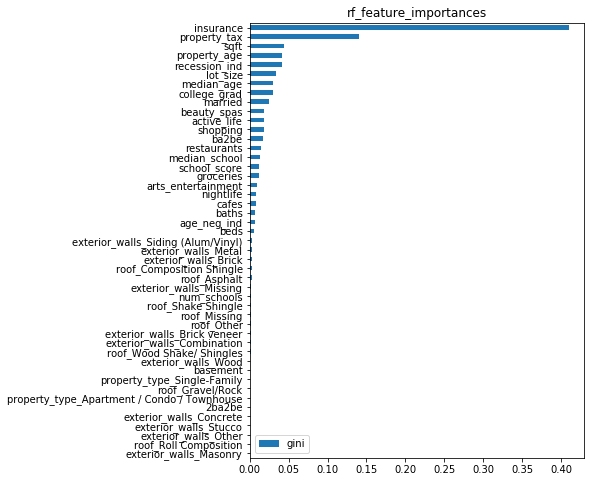

In [120]:
plot_feature_importance(X.columns, fitted_final_models['rf'][1].feature_importances_, 'rf_feature_importances', 'gini')

**CHECK DONE: All final models are saved correctly.**

**Feature Importance**
1. as expected and observed, property tax and insurance, property size related features are most predictive.
2. recession indicator has some predictive power, which also makes sense, as macro environment plays a big role in real assets pricing.
2. building materials, be it wall or roof, are of almost no importance in predicing the price.

**References:**
1. https://github.com/hyperopt/hyperopt-sklearn/blob/master/hpsklearn/components.py
2. https://www.linkedin.com/pulse/approaching-almost-any-machine-learning-problem-abhishek-thakur
3. sklearn RandomForestRegressor